**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import gc
import datetime as datetime
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [2]:
df = pd.read_csv('nct_dream_data.csv',encoding = 'unicode_escape')
df.head()

,title,publishedAt,viewCount,likeCount,commentCount,duration,memberCount,category,keywords,subscriberCount
0,"DREAM SKETCH : Page #1 - Concert Meeting, Post...",2022-11-25T13:00:40Z,411160,56214,1624,1682,7.0,BTS,"BTS, Concert",5.34
1,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-24T23:00:09Z,112087,23301,350,31,7.0,Teaser,"Promotion, Movie, Trailer",5.34
2,????NCTzens ??????????????????? #NAGOYA#NCTDRE...,2022-11-24T04:27:05Z,91345,24341,140,37,7.0,Shorts,"Shorts, Concert",5.34
3,???????????? ??? ?????????????? ??? ??? ?????...,2022-11-23T13:00:17Z,772833,101486,2409,1157,7.0,Jakun,"Jakun, Games",5.34
4,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-17T23:00:21Z,168691,31192,474,31,7.0,Teaser,"Promotion, Movie, Trailer",5.32


# Data Wrangling

**Delete videos that are "Shorts"**

In [3]:
df=df[df['category']!="Shorts"]
print(f'df has {len(df)} rows after removing shorts')
df.reset_index(drop=True, inplace=True)


df has 348 rows after removing shorts


**Change the string of 'publishedAt' to DateTime** <br>

In [4]:
#Change publishedAt format to datetime (only date)
def to_date(iso_datetime):
    date = iso_datetime.split('T')[0]
    return date

df['publishedAt'] = pd.to_datetime(df['publishedAt'].apply(to_date))
df.head()

,title,publishedAt,viewCount,likeCount,commentCount,duration,memberCount,category,keywords,subscriberCount
0,"DREAM SKETCH : Page #1 - Concert Meeting, Post...",2022-11-25,411160,56214,1624,1682,7.0,BTS,"BTS, Concert",5.34
1,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-24,112087,23301,350,31,7.0,Teaser,"Promotion, Movie, Trailer",5.34
2,???????????? ??? ?????????????? ??? ??? ?????...,2022-11-23,772833,101486,2409,1157,7.0,Jakun,"Jakun, Games",5.34
3,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-17,168691,31192,474,31,7.0,Teaser,"Promotion, Movie, Trailer",5.32
4,NCT DREAM ????????? ?????? 'Dream-lapse' Perfo...,2022-11-08,1067784,139749,4347,175,7.0,Performance Video,"Performance Video, Stage, Performance",5.30


**Add the duration of days past since the data is collected**

In [5]:
# date_collected = '2022-11-26'.
df['daysPassed'] = (pd.to_datetime('2022-11-26')-df['publishedAt']).dt.days.astype('int')
df.head()

,title,publishedAt,viewCount,likeCount,commentCount,duration,memberCount,category,keywords,subscriberCount,daysPassed
0,"DREAM SKETCH : Page #1 - Concert Meeting, Post...",2022-11-25,411160,56214,1624,1682,7.0,BTS,"BTS, Concert",5.34,1
1,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-24,112087,23301,350,31,7.0,Teaser,"Promotion, Movie, Trailer",5.34,2
2,???????????? ??? ?????????????? ??? ??? ?????...,2022-11-23,772833,101486,2409,1157,7.0,Jakun,"Jakun, Games",5.34,3
3,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-17,168691,31192,474,31,7.0,Teaser,"Promotion, Movie, Trailer",5.32,9
4,NCT DREAM ????????? ?????? 'Dream-lapse' Perfo...,2022-11-08,1067784,139749,4347,175,7.0,Performance Video,"Performance Video, Stage, Performance",5.30,18


**Fill in empty data for Subscribers using fitting** <br>
Youtube API does not provide the number of subscribers by date. I have achieved 82 (or 6 months worth) of subscriber count data from third party. This data will be used for analysis and prediction of the previous empty data.

Text(0, 0.5, 'subscribers')

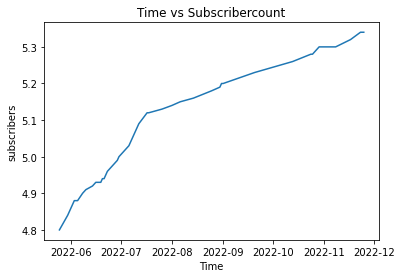

In [6]:
# Visualize non NAN columns for subscriberCount
df_sub= df[['publishedAt','subscriberCount']]
df_sub = df_sub.dropna()

plt.plot(df_sub['publishedAt'],df_sub['subscriberCount'])
plt.title('Time vs Subscribercount')
plt.xlabel("Time")
plt.ylabel("subscribers")

From the plot, we can interpret that the number of subscribers are increasing. The increasing trend seems somewhat linear but also seems to concave downwards. <br>
We will fit this data to a logarithmic fit 

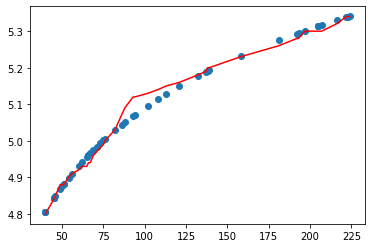

In [7]:
df_sub['toOrdinal']=df_sub['publishedAt'].apply(lambda x: x.toordinal())
x = np.array(df_sub['toOrdinal'])
y = np.array(df_sub['subscriberCount'])

#fit the log value of x(date created). Find an arbitrary number to deduct from x to fit the plot
x = x-738260
x_log = np.log(x)
a,b = np.polyfit(x_log,y,1)
plt.plot(x,a*x_log+b,'o')
plt.plot(x,y,'r')

This logarithmic regression does very well with the limited data we have. <br>
However, the ordinal date the channel has been created is smaller than the number we deduct from x. Thus, this result in logarithm of a negative number, which is not a real number.<br>
So, in this case, we will add data which has the ordinal date equal to when the channel has been made and set the subscriber to 0.<br>
The subscriber data that I have achieved from third party data is in millions. Therefore, even if there were minimal subscribers on the very day the channel was made, it is small enough to ignore.<br>
Now, with the added data, we will see if we can fit an ordinary least squares 

[-1.98573307e+03  2.69621181e-03]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.184e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           4.22e-60
Time:                        04:15:47   Log-Likelihood:                 84.136
No. Observations:                  51   AIC:                            -164.3
Df Residuals:                      49   BIC:                            -160.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1985.7

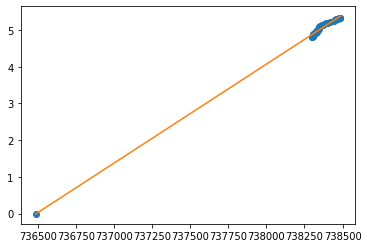

In [8]:
import statsmodels.api as sm

#Add the date of the creation of account and subscriber to 0 at the time
x = np.array(df_sub['toOrdinal'])
y = np.array(df_sub['subscriberCount'])
y = np.append(y,0)
date_created = datetime.datetime.strptime('7/6/17',"%d/%m/%y").toordinal()
x = np.append(x,date_created)

# Run an ordinary least squares for linear regression
x_const= sm.add_constant(x) #for constant parameter

ols_fit = sm.OLS(y,x_const).fit()
print(ols_fit.params)
print(ols_fit.summary())

ypred = ols_fit.predict(x_const)
plt.plot(x[:82],y[:82],'o')
plt.plot(x[:82],ypred[:82])

From the OLS summary, both R-squared and adjusted R-squared are large(0.990,0.989>0.975) andd the p value is very small (<0.05). We can say that the model does not have enough evidence to be insignificant. Therefore, we will use this model for the NaN data for subscriber count.

0      5.340000
1      5.340000
2      5.340000
3      5.320000
4      5.300000
5      5.300000
6      5.300000
7      5.300000
8      5.300000
9      5.280000
10     5.280000
11     5.260000
12     5.230000
13     5.200000
14     5.200000
15     5.190000
16     5.180000
17     5.160000
18     5.150000
19     5.140000
20     5.130000
21     5.120000
22     5.120000
23     5.090000
24     5.070000
25     5.030000
26     5.000000
27     4.990000
28     4.980000
29     4.970000
30     4.960000
31     4.940000
32     4.940000
33     4.930000
34     4.930000
35     4.920000
36     4.910000
37     4.900000
38     4.880000
39     4.880000
40     4.880000
41     4.880000
42     4.850000
43     4.840000
44     4.840000
45     4.840000
46     4.840000
47     4.800000
48     4.800000
49     4.800000
50     4.822198
51     4.822198
52     4.805900
53     4.803184
54     4.797751
55     4.797751
56     4.786886
57     4.781454
58     4.776021
59     4.770588
60     4.765156
61     4.759723
62     4

25

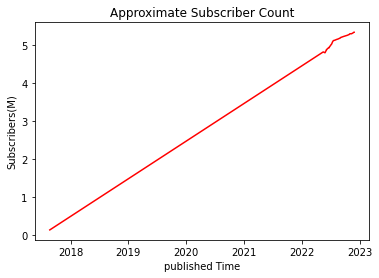

In [9]:
def subscriberPred(x): #from ols params above
    return -2000.58514 + 0.00271629042 *x

df_sub2=df[['publishedAt']].copy()
df_sub2['toOrdinal'] = df_sub2['publishedAt'].apply(lambda x: x.toordinal())
df_sub2 = df_sub2.drop(['publishedAt'],axis=1)
df_sub2['subscriberCountPred'] = df_sub2['toOrdinal'].apply(subscriberPred)

df['subscriberCountPred'] = df_sub2['subscriberCountPred']
df['subscriberCountPred'][:50] = df['subscriberCount'][:50]

plt.plot(df['publishedAt'],df['subscriberCountPred'],color="red")
plt.title("Approximate Subscriber Count")
plt.xlabel("published Time")
plt.ylabel("Subscribers(M)")
print(df['subscriberCountPred'].to_string())
# Delete sub dataframes
del df_sub
del df_sub2

gc.collect()

**Label Category** <br>
From the 'keywords' column, create columns with significant keywords.<br>
Label each video as 1 if 'keywords' include the keyword and 0 if not.
(Keywords are manually added)

In [10]:
#Categories
keywords = ['jakun','bts','comeback','performance','stage','teaser','reaction',
    'music video', 'advertisement', 'track', 'promotion', 'recording','dance',
    'audio', 'liveperformance', 'album'] 
#unboxing = jakun + album
#dvsd = jakun + comeback

In [11]:
# Change to all lower case for category and keywords
df['keywords']=df['keywords'].str.lower()
df['category']=df['category'].str.lower()

# Create one hot encoding for the categories
for i in keywords :
    df[i] = df.apply(lambda row: 1 if (i in row['keywords']) or (i in row['category']) else 0,axis=1)

Explanation of Keywords(Categories):
* Jakun = In-house created themed show (Travel, Cooking, Game, etc..)
* BTS = Behind the Scenes of recording album, album photoshoot, stages etc..
* comeback = Videos related to the release of new album
* performance = Videos where the K-pop band sings and/or dances
* stage = Videos where the K-pop band performed officially on stage
* teaser = teaser for music videos, movies, concerts, etc
* reaction = Video where the band films themselves watching and reacting to other videos
* music video = Music videos of songs which are not the main track (main track music videos are uploaded on another channel)
* advertisement = Videos related to the advertisements the band is doing (cosmetics, food, bank)
* track = Track videos. They are similar to music videos but usually a video for half of the track before the album releases
* promotion = Videos where the band promotes their merchandise, concert etc
* recording = Videos of the K-pop band recording their music tracks
* dance = Videos of the band dancing (stage, practice etc)
* audio = audio of the tracks of album or medley of the highlights of the full album
* liveperformance = Videos where the band performs live (doesn't necessarily have to be on a stage. Could be casual.)
* album = Anything related to their album (unboxing of album, photoshoot of album..)
Other keywords that are not included
* dvsd : comeback + jakun
* unboxing = jakun + album
* facecam, dvsd,replay,concert, game, recap, highlight medley,unboxing

# Data Analysis

In [12]:
for i in keywords :
    print(f"Number of videos in category {i:15} : {len(df[df[i]==1]):5}")

Number of videos in category jakun           :    83
Number of videos in category bts             :    94
Number of videos in category comeback        :   160
Number of videos in category performance     :   106
Number of videos in category stage           :   121
Number of videos in category teaser          :    31
Number of videos in category reaction        :     7
Number of videos in category music video     :    19
Number of videos in category advertisement   :     7
Number of videos in category track           :    10
Number of videos in category promotion       :    29
Number of videos in category recording       :    10
Number of videos in category dance           :    82
Number of videos in category audio           :    16
Number of videos in category liveperformance :     3
Number of videos in category album           :     8


The categories worth looking at individually are : Jakun, BTS, comeback, performance, stage, dance

**Relationship between keywords and total number of views**

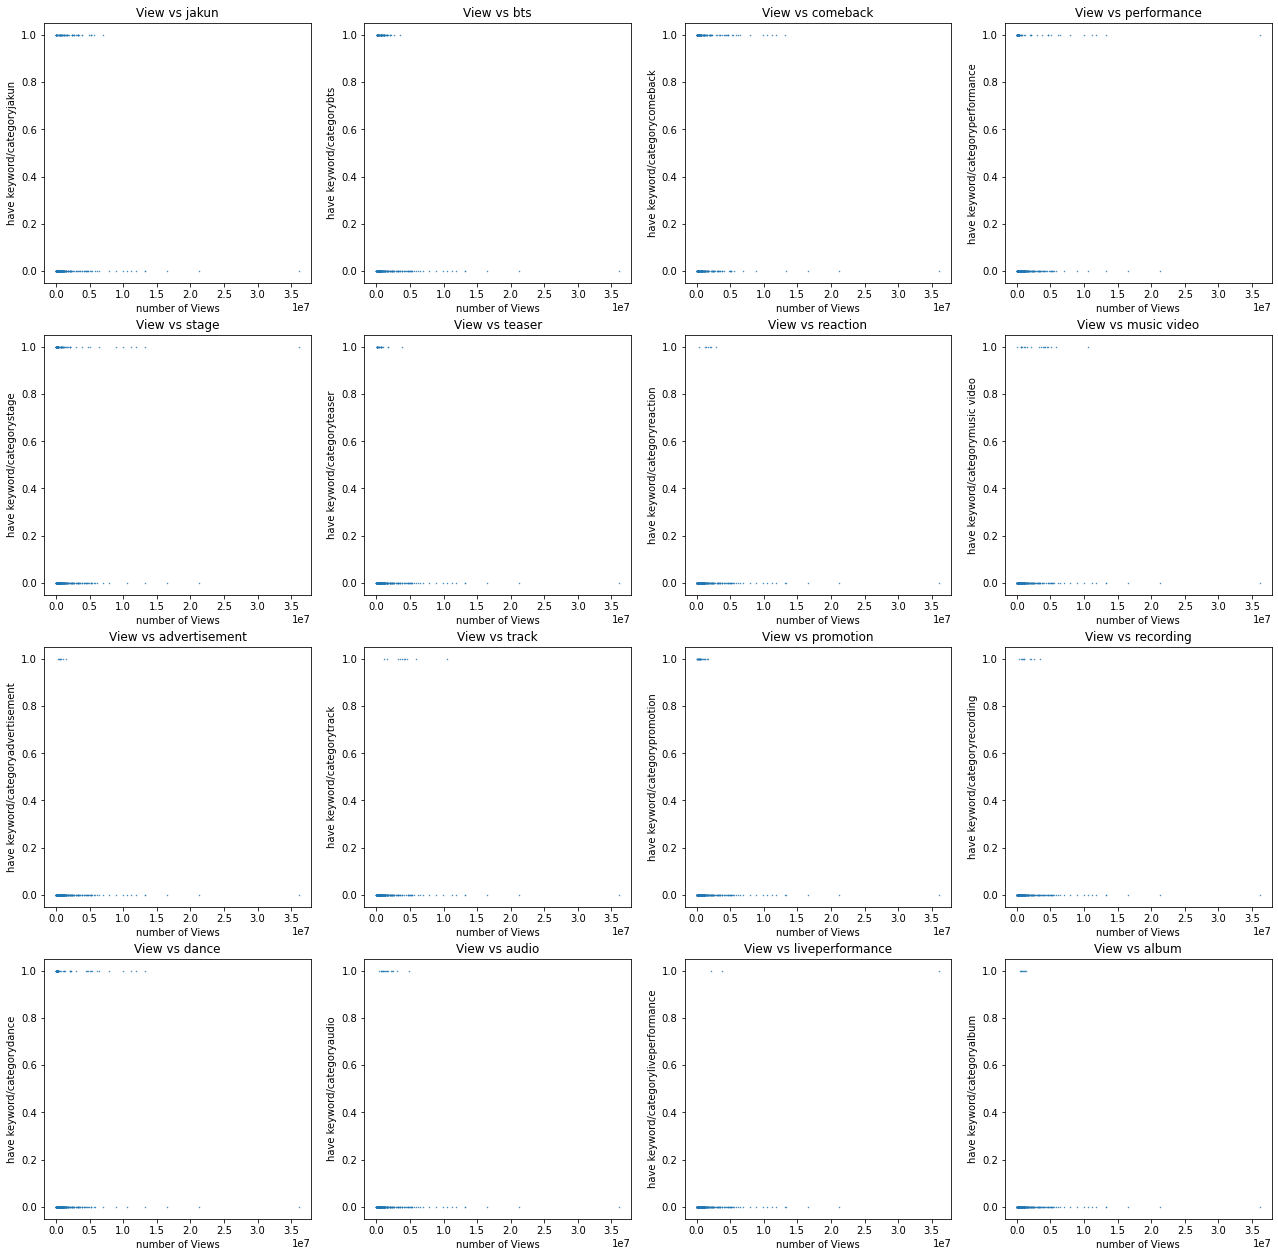

In [13]:
fig, axes = plt.subplots(4,4,figsize=(22, 22))
for i in range(len(keywords)):
    axes[int(i/4),int(i%4)].scatter(df['viewCount'],df[keywords[i]],s=0.2)
    axes[int(i/4),int(i%4)].set_title('View vs ' +keywords[i])
    axes[int(i/4),int(i%4)].set_xlabel('number of Views')
    axes[int(i/4),int(i%4)].set_ylabel('have keyword/category' + keywords[i])


The above is a graph of 'viewCount' vs each keyword(category)<br>
The Y value is 1 for videos that contain the keywords and 0 for those that do not.
* We can see that there are only three videos over the view of 1.5+e7. These videos could be considered as an outlier in our model. However, from a business aspect, it could be analysed and interpreted as very valuable information to deterimine which videos get viral within the K-pop fandom (or even the general public) and why.
* Most of the graphs are consistent in terms of views, but some categories have videos where most of them have very small views where as a few have very large amount of views. This might be because there was something special about those videos or was included in other categories that have a higher tendency to gain more views.
* In general, we can see that the more popular videos are under categories 'Stage', 'Performance','Comeback', 'Jakun', 'Dance', 'Music Video'. The less popular videos are under the categories 'Audio', 'Teaser', 'Behind the Scenes', 'Advertisement', 'Album', 'Rection', 'Promotion'. The more vague categories are 'Track', 'Live Performance', 'Recording'.

**Relationship between duration and views for different categories**

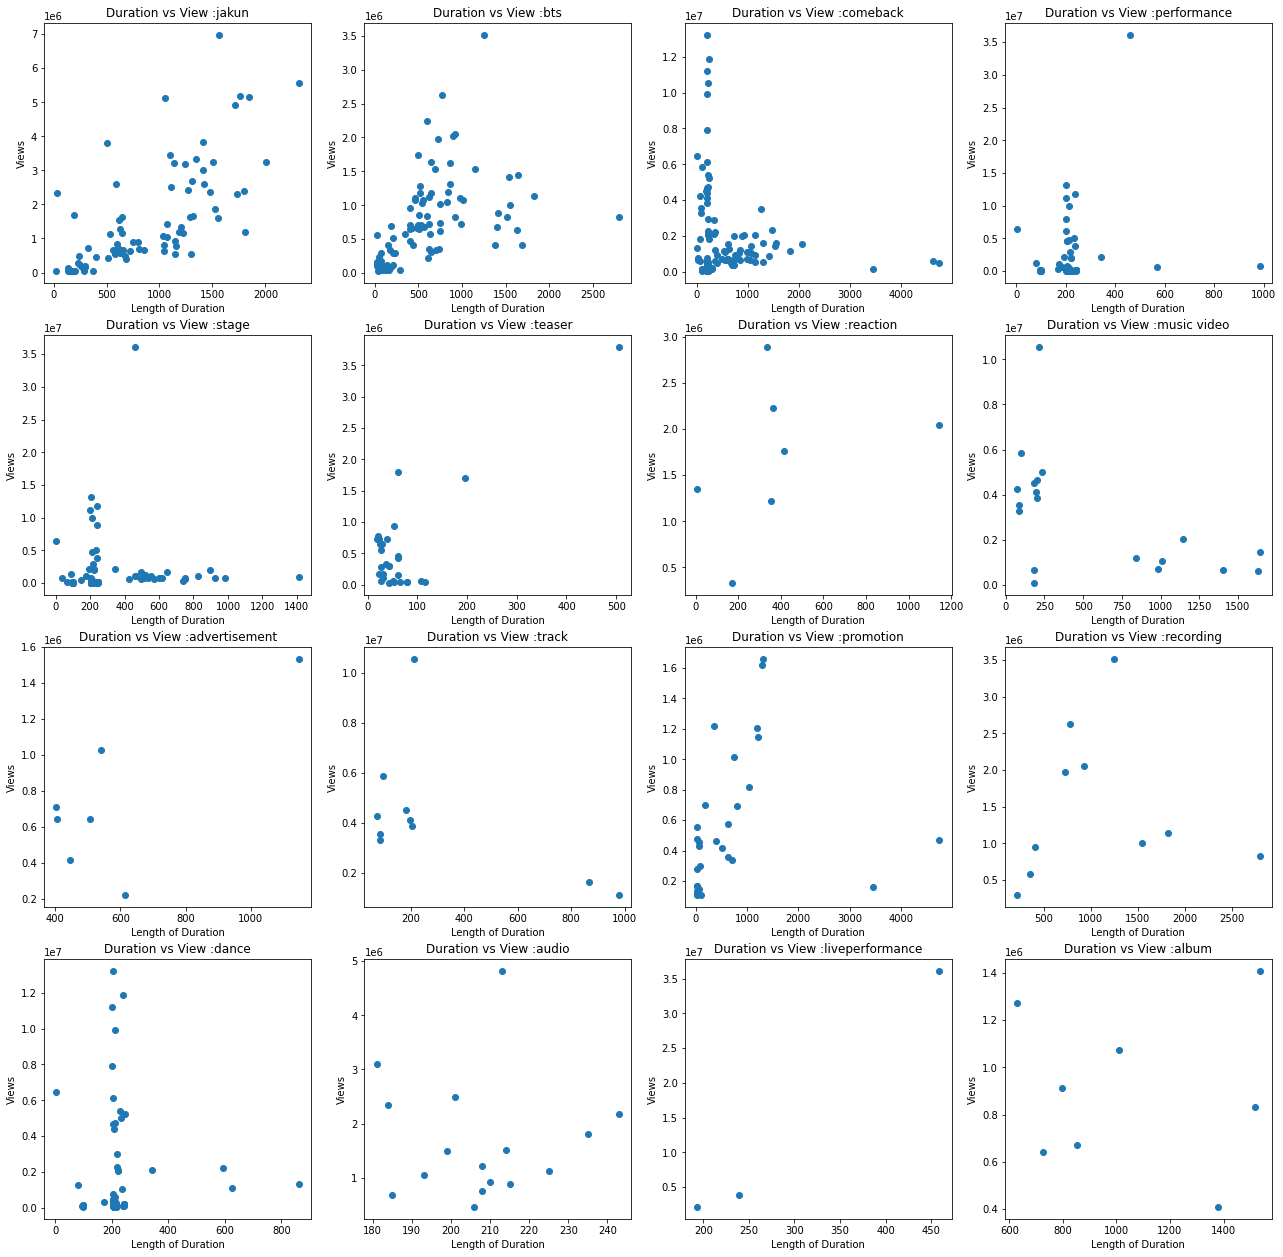

In [14]:
fig, axes = plt.subplots(4,4,figsize=(22, 22))
for i in range(len(keywords)):
    df_sub = df[df[keywords[i]]==1]
    axes[int(i/4),int(i%4)].scatter(df_sub['duration'],df_sub['viewCount'])
    axes[int(i/4),int(i%4)].set_title('Duration vs View :' +keywords[i])
    axes[int(i/4),int(i%4)].set_xlabel('Length of Duration')
    axes[int(i/4),int(i%4)].set_ylabel('Views')

The above graph shows some correlation between duration and views for videos with categories 'Jakun', 'BTS, and a little bit for 'Promotion'

In [15]:
j_corr = df[df['jakun']==1][['duration','viewCount']].corr()
bts_corr = df[df['bts']==1][['duration','viewCount']].corr()
pro_corr = df[df['promotion']==1][['duration','viewCount']].corr()
print('Jakun correlation')
print(j_corr)
print("\nBehind the Scenes correlation")
print(bts_corr)
print("\nPromotion correlation")
print(pro_corr)

Jakun correlation
           duration  viewCount
duration    1.00000    0.70846
viewCount   0.70846    1.00000

Behind the Scenes correlation
           duration  viewCount
duration   1.000000   0.493029
viewCount  0.493029   1.000000

Promotion correlation
           duration  viewCount
duration   1.000000   0.217835
viewCount  0.217835   1.000000


* Within the category 'Jakun', views have a quite high correlation between the duration of videos - 0.71
* Within the category 'Behind the Scenes', views have moderate to low correlation with duration - 0.49
* Within the category 'Promotion', views have a weak correlation with duration - 0.22
<br>
The analysis we can make here is that the category 'Jakun' is enjoyable for more fans if they are longer. This could be because of different reasons, but generally longer 'Jakun's have a stronger theme such as the group travelling to the countryside or playing games. These videos are targeted to be watched and enjoyed similar to tv shows. Shorter 'Jakun's usually have a tendency to be promoting merchandise. The differences of the characteristics of longer and shorter 'Jakun's could be the reason for this correlation.

**Correlation between all features**

In [16]:
df.corr()

,viewCount,likeCount,commentCount,duration,memberCount,subscriberCount,daysPassed,subscriberCountPred,jakun,bts,...,reaction,music video,advertisement,track,promotion,recording,dance,audio,liveperformance,album
viewCount,1.000000,0.823495,0.543422,0.037163,0.270817,-0.367836,-0.159647,0.158716,-0.001910,-0.159330,...,0.007443,0.121202,-0.037073,0.154821,-0.095886,-0.001808,-0.003849,0.010809,0.382569,-0.031585
likeCount,0.823495,1.000000,0.805643,0.111354,0.433789,-0.323131,-0.276156,0.275374,0.081228,-0.153356,...,0.066235,0.304604,-0.017892,0.371865,-0.109602,0.028503,-0.107680,-0.044992,0.214575,-0.014158
commentCount,0.543422,0.805643,1.000000,0.106514,0.315798,-0.160886,-0.186014,0.185899,0.108443,-0.133544,...,-0.009074,0.379561,-0.016647,0.504435,-0.098418,0.032573,-0.124263,-0.022439,0.207685,-0.027038
duration,0.037163,0.111354,0.106514,1.000000,0.334936,-0.037598,-0.306805,0.308039,0.292398,0.070468,...,-0.024731,0.016385,0.014616,-0.055542,0.077777,0.147840,-0.245765,-0.100998,-0.030308,0.125738
memberCount,0.270817,0.433789,0.315798,0.334936,1.000000,0.415239,-0.190506,0.192416,0.154207,0.314206,...,0.112763,0.173945,0.030464,0.119207,0.215041,0.144356,-0.355734,-0.377474,0.078261,0.128736
subscriberCount,-0.367836,-0.323131,-0.160886,-0.037598,0.415239,1.000000,-0.965325,1.000000,0.070336,0.042109,...,-0.180843,-0.197969,0.184497,NaN,0.204890,-0.066638,-0.189047,-0.368457,NaN,-0.216765
daysPassed,-0.159647,-0.276156,-0.186014,-0.306805,-0.190506,-0.965325,1.000000,-0.999910,0.078191,0.117927,...,-0.028193,-0.018620,-0.094352,0.007711,-0.138886,0.014809,-0.053030,-0.185309,-0.067120,-0.092329
subscriberCountPred,0.158716,0.275374,0.185899,0.308039,0.192416,1.000000,-0.999910,1.000000,-0.076861,-0.116778,...,0.027929,0.017870,0.095098,-0.008136,0.139323,-0.014764,0.052193,0.183248,0.066686,0.092092
jakun,-0.001910,0.081228,0.108443,0.292398,0.154207,0.070336,0.078191,-0.076861,1.000000,-0.143043,...,-0.080184,-0.134492,-0.080184,-0.096263,0.050826,-0.096263,-0.310729,-0.122859,-0.052188,0.094121
bts,-0.159330,-0.153356,-0.133544,0.070468,0.314206,0.042109,0.117927,-0.116778,-0.143043,1.000000,...,-0.041063,0.053206,0.235518,-0.027161,0.097565,0.282745,-0.276767,-0.133548,-0.056728,0.079417


The notable correlations here are between (viewCount, likeCount), (commentCount, viewCount). For viewCount and likeCount, it is likely for fans to press the like button if they watch a video. Therefore, as the views go up, the likes go up as well. For commentCount and viewCount, the correlation is moderate. But if we take into account that some videos are classified as children's videos and comments are not allowed, we can predict that the correlation will increase if the comments are allowed.<br>
One thing to note for likeCount and commentCount is that we cannot predict views with these prior to upload. When these data are provided, viewCount is also provided. Therefore, it is not reasonable to use these as features in the prediction model.

The correlation between subscriberCountPred and subscriberCount is 1 since we derived subscriberCountPred from subscriberCount. However, one thing to notice is that daysPassed has a negative correlation by -0.999905 with subscriberCountPred. This is because we the date for both features. <br>
The issue that arises from this is if the views of a video is more reliant on the number of subscribers the channel had when it was released or if it's more reliant on how long it has been watched from the day the data was collected. Which is the more important feature when it comes to views?

**More analysis for separate categories**

In [17]:
df_j = df[df['jakun']==1]
df_j.corr()

,viewCount,likeCount,commentCount,duration,memberCount,subscriberCount,daysPassed,subscriberCountPred,jakun,bts,...,reaction,music video,advertisement,track,promotion,recording,dance,audio,liveperformance,album
viewCount,1.000000,0.924488,0.771411,0.708460,0.480619,-0.034420,-0.397179,0.395385,NaN,-0.309614,...,NaN,NaN,NaN,NaN,-0.128462,NaN,NaN,NaN,NaN,-0.094624
likeCount,0.924488,1.000000,0.916552,0.616042,0.483536,-0.124118,-0.491902,0.491145,NaN,-0.321499,...,NaN,NaN,NaN,NaN,-0.110211,NaN,NaN,NaN,NaN,-0.060403
commentCount,0.771411,0.916552,1.000000,0.413764,0.397949,-0.132579,-0.349061,0.349152,NaN,-0.266757,...,NaN,NaN,NaN,NaN,-0.138547,NaN,NaN,NaN,NaN,-0.092224
duration,0.708460,0.616042,0.413764,1.000000,0.576486,0.449538,-0.631292,0.630393,NaN,-0.409029,...,NaN,NaN,NaN,NaN,0.047338,NaN,NaN,NaN,NaN,-0.043792
memberCount,0.480619,0.483536,0.397949,0.576486,1.000000,-0.149407,-0.477724,0.477252,NaN,-0.348063,...,NaN,NaN,NaN,NaN,0.104224,NaN,NaN,NaN,NaN,0.158749
subscriberCount,-0.034420,-0.124118,-0.132579,0.449538,-0.149407,1.000000,-0.951791,1.000000,NaN,-0.602405,...,NaN,NaN,NaN,NaN,-0.012451,NaN,NaN,NaN,NaN,-0.355681
daysPassed,-0.397179,-0.491902,-0.349061,-0.631292,-0.477724,-0.951791,1.000000,-0.999899,NaN,0.350428,...,NaN,NaN,NaN,NaN,-0.246113,NaN,NaN,NaN,NaN,-0.137074
subscriberCountPred,0.395385,0.491145,0.349152,0.630393,0.477252,1.000000,-0.999899,1.000000,NaN,-0.351496,...,NaN,NaN,NaN,NaN,0.246460,NaN,NaN,NaN,NaN,0.135669
jakun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bts,-0.309614,-0.321499,-0.266757,-0.409029,-0.348063,-0.602405,0.350428,-0.351496,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.062942,NaN,NaN,NaN,NaN,-0.096970


# Data Modeling

The obstacle of creating this model is decide the prediction of views how long after they have been up. The views of a video that has been up for a day will be extremely different from the views after a month whereas the views after two months will not be very different from views after years. By comparing the data collected a month ago, the conclusion was that views don't change much after two months. So, the views prediction will be considered as views of a video two months after uploading.
<br>
The issue that might arise is that there are videos collected within two months of upload. Creating a model with these data and without these data will give a more clear idea to how important the duration of the video is and after what point duration becomes insignificant.

**Decision Trees**

In [19]:
from sklearn.model_selection import train_test_split

X = np.array(df[['duration','memberCount','daysPassed','subscriberCountPred','jakun','bts','comeback',
              'performance','stage','teaser','reaction','music video', 'advertisement', 'track',
              'promotion', 'recording','dance','audio', 'liveperformance', 'album']])
y = np.array(df['viewCount'])

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=5)
#number of train & test
print(f"Shape of X_train : {X_train.shape} \n Shape of X_test : {X_test.shape}")



Shape of X_train : (261, 20) 
 Shape of X_test : (87, 20)


In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(n_estimators=500, random_state = 42)
# rf.fit(X_train,y_train)

# from sklearn.metrics import r2_score, mean_squared_error
# pred = rf.predict(X_test)
# print(mean_squared_error(y_test,pred))
# for i in range(len(pred)):
#     print(f"Prediction : {pred[i]:20}, Real Value : {y_test[i]:8}, Accuracy : {pred[i]/y_test[i]*100:5}%")

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# rf = RandomForestRegressor(random_state=5)
# param_grid = {'bootstrap':[True,False],
#               'max_depth' : [10,20,30,40,50,60,70,80],
#               'max_features' : ['auto','sqrt'],
#               'min_samples_leaf' :[1,2,4,8],
#               'min_samples_split' : [2,5,10],
#               'n_estimators' : [10,100,200,400,800,1000,1200,1500,1800,2000]}

# rf_rand = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_iter=100,cv=3,verbose=2,
#                             random_state=5,n_jobs = -1)
# rf_rand.fit(X_train, y_train)
# rf_rand.best_params_
# rand_best_model = rf_rand.best_estimator_
# rand_best_model.fit(X_train,y_train)
# print(mean_squared_error(y_test,rand_best_model.predict(X_test)))